In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
# Time series analysis libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
# Set random seed for reproducibility
np.random.seed(42)

====================================
=================================
PART 1: DATA GENERATION AND
EXPLORATION
====================================
=================================

In [6]:
def generate_network_traffic_data(days=365, noise_level=0.1):
    """
    Generate realistic network traffic data with multiple patterns:
    - Daily cycles (higher during business hours)
    - Weekly patterns (lower on weekends)
    - uhoh
    - wowowowowowowowo
    """
    # Create datetime index
    start_date = datetime(2023, 1, 1)
    dates = pd.date_range(start_date, periods=days*24, freq='H')

    # Base traffic level
    base_traffic = 100

    # Daily pattern (higher during 8 AM - 6 PM)
    hours = np.array([d.hour for d in dates])
    daily_pattern = (
        50 * (1 + np.sin((hours - 6) * 2 * np.pi / 24)) *
        (hours >= 6) * (hours <= 22)
    )

    # Weekly pattern (lower on weekends)
    weekdays = np.array([d.weekday() for d in dates]) # 0=Monday, 6=Sunday
    weekly_pattern = np.where(weekdays < 5, 20, -30) # Weekday boost, weekend reduction

    # Long-term trend (gradual increase over time)
    trend = np.linspace(0, 30, len(dates))

    # Seasonal pattern (higher traffic in winter months)
    day_of_year = np.array([d.timetuple().tm_yday for d in dates])
    seasonal_pattern = 15 * np.sin((day_of_year - 80) * 2 * np.pi / 365)

    # Random noise
    noise = np.random.normal(0, noise_level * base_traffic, len(dates))

    # Combine all components
    traffic = (base_traffic + daily_pattern + weekly_pattern + trend +
               seasonal_pattern + noise)

    # Add some random spikes (network congestion events)
    spike_indices = np.random.choice(len(dates), size=int(len(dates) * 0.01), replace=False)
    traffic[spike_indices] += np.random.exponential(50, len(spike_indices))

    # Ensure no negative values
    traffic = np.maximum(traffic, 5)

    return pd.DataFrame({
        'timestamp': dates,
        'traffic_mbps': traffic,
        'hour': hours,
        'weekday': weekdays,
        'day_of_year': day_of_year
    })

# Generate the dataset
print("Getting dingo dongo network traffic dataset...")
df = generate_network_traffic_data(days=365)
df.set_index('timestamp', inplace=True)
print(f"Dataset ssssssshape: {df.shape}")
print(f"Date rrrrrrange: {df.index.min()} to {df.index.max()}")
print("\nFirst few rows:")
print(df.head())

Getting dingo dongo network traffic dataset...
Dataset ssssssshape: (8760, 4)
Date rrrrrrange: 2023-01-01 00:00:00 to 2023-12-31 23:00:00

First few rows:
                     traffic_mbps  hour  weekday  day_of_year
timestamp                                                    
2023-01-01 00:00:00     60.299416     0        6            1
2023-01-01 01:00:00     53.953057     1        6            1
2023-01-01 02:00:00     61.816010     2        6            1
2023-01-01 03:00:00     70.572849     3        6            1
2023-01-01 04:00:00     53.004441     4        6            1


====================================
=================================
PART 2: EXPLORATORY DATA ANALYSIS
====================================
=================================



EXPLORATORY DATA ANALYSIS

Basic Statistics:
count    8760.000000
mean      167.354212
std        47.937579
min        39.859867
25%       133.520467
50%       164.934833
75%       206.818578
max       390.064894
Name: traffic_mbps, dtype: float64


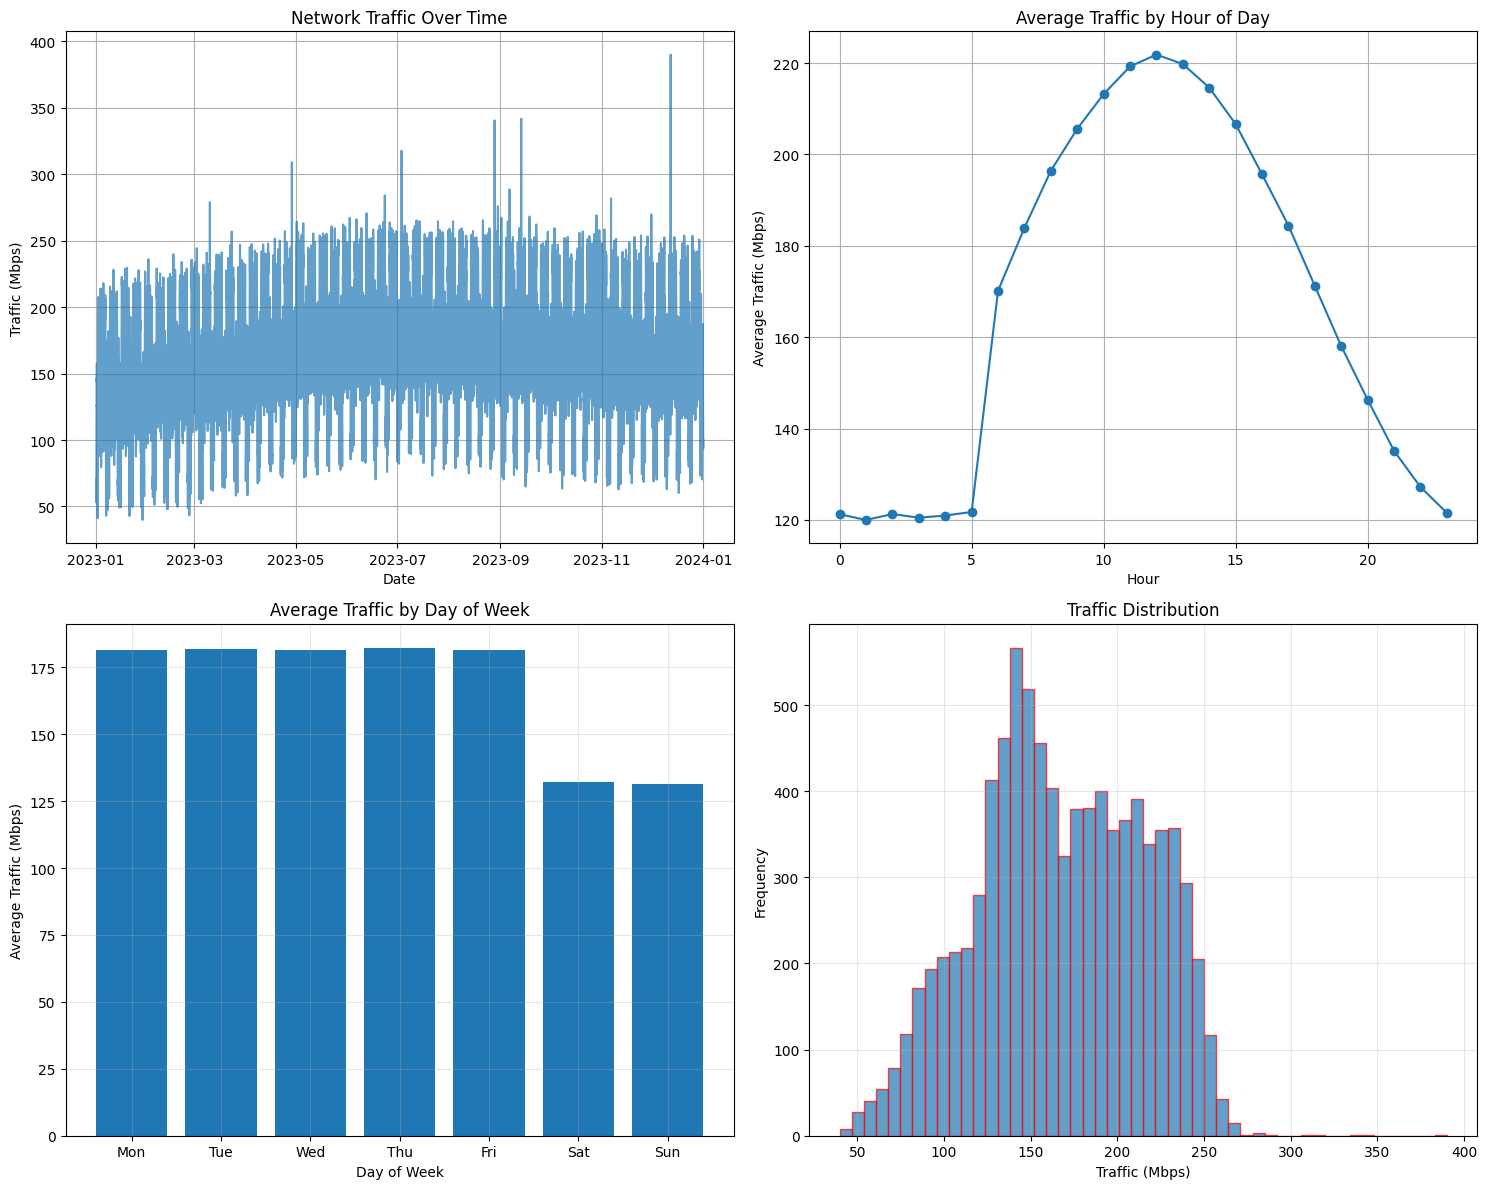


Performing seasonal decomposition...


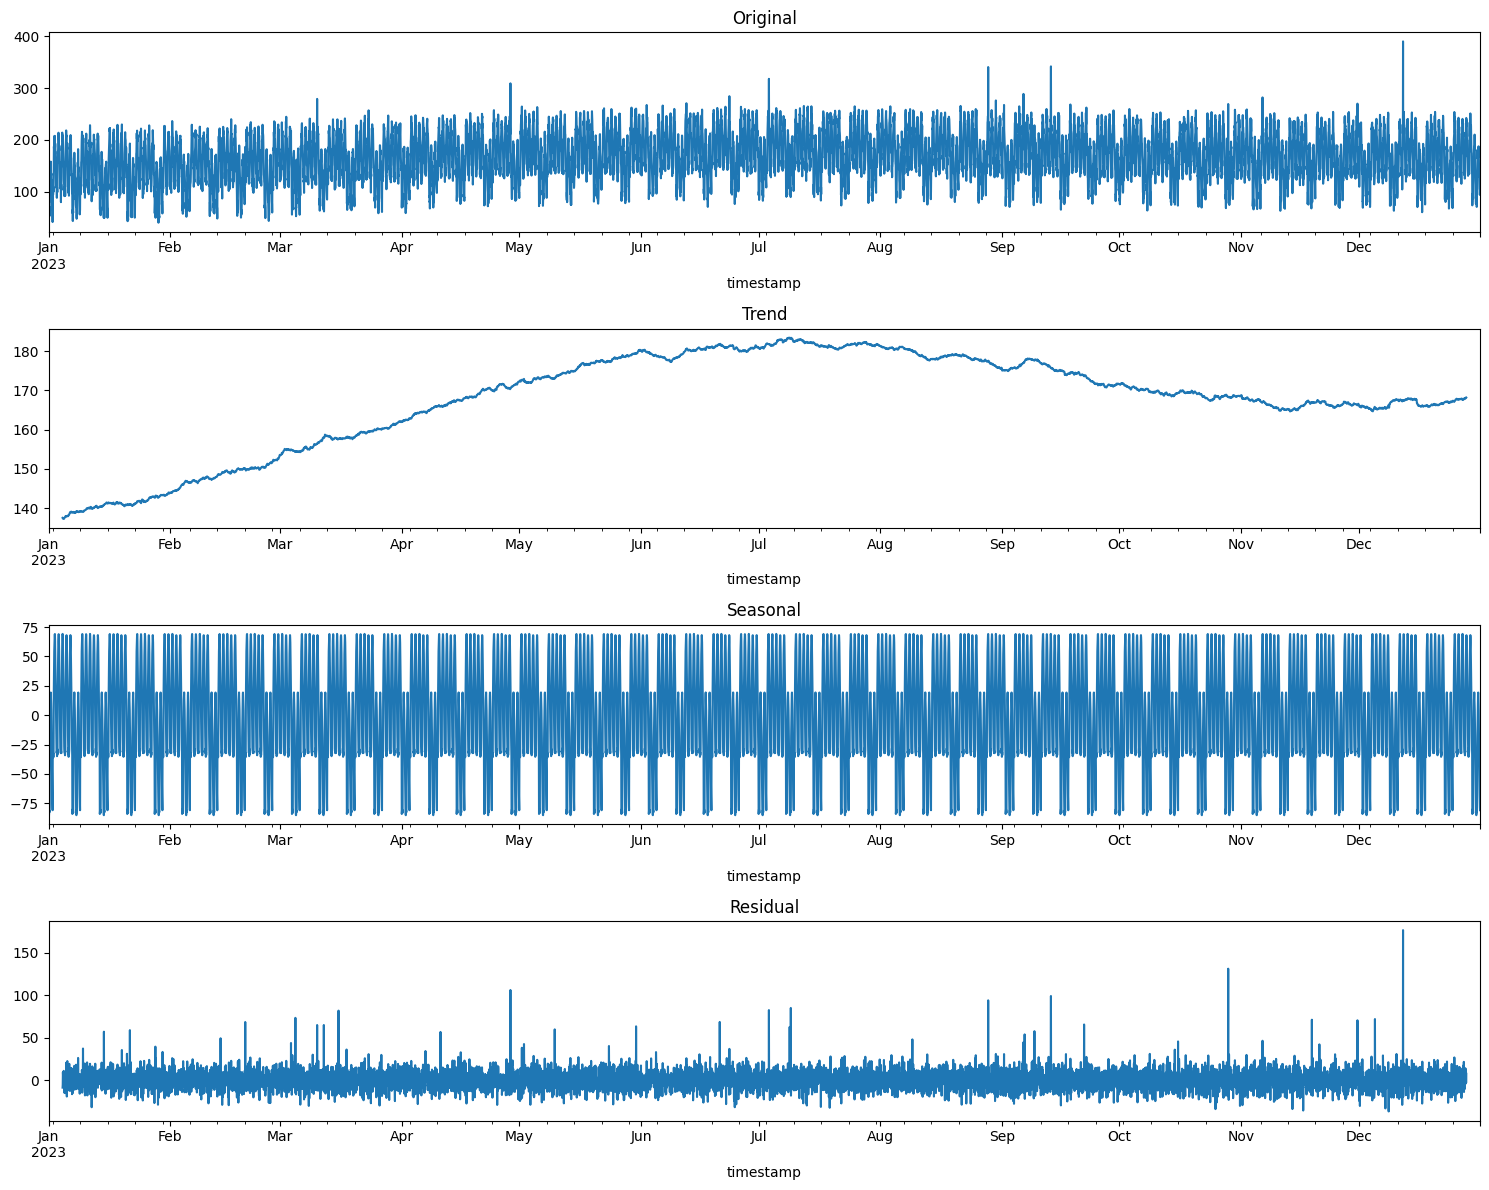

In [8]:
def perform_eda(df):
    """Perform comprehensive exploratory data analysis"""
    print("\n" + "="*50)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*50)
    # Basic statistics
    print("\nBasic Statistics:")
    print(df['traffic_mbps'].describe())
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    # Time series plot
    axes[0,0].plot(df.index, df['traffic_mbps'], alpha=0.7)
    axes[0,0].set_title('Network Traffic Over Time')
    axes[0,0].set_xlabel('Date')
    axes[0,0].set_ylabel('Traffic (Mbps)')
    axes[0,0].grid(True)
    # Daily pattern
    daily_avg = df.groupby('hour')['traffic_mbps'].mean()
    axes[0,1].plot(daily_avg.index, daily_avg.values, marker='o')
    axes[0,1].set_title('Average Traffic by Hour of Day')
    axes[0,1].set_xlabel('Hour')
    axes[0,1].set_ylabel('Average Traffic (Mbps)')
    axes[0,1].grid(True)
    # Weekly pattern
    weekday_avg = df.groupby('weekday')['traffic_mbps'].mean()
    weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    axes[1,0].bar(range(7), weekday_avg.values)
    axes[1,0].set_title('Average Traffic by Day of Week')
    axes[1,0].set_xlabel('Day of Week')
    axes[1,0].set_ylabel('Average Traffic (Mbps)')
    axes[1,0].set_xticks(range(7))
    axes[1,0].set_xticklabels(weekday_names)
    axes[1,0].grid(True, alpha=0.3)
    # Distribution
    axes[1,1].hist(df['traffic_mbps'], bins=50, alpha=0.7,
    edgecolor='red')
    axes[1,1].set_title('Traffic Distribution')
    axes[1,1].set_xlabel('Traffic (Mbps)')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    # Seasonal decomposition
    print("\nPerforming seasonal decomposition...")
    decomposition = seasonal_decompose(df['traffic_mbps'],
    model='additive', period=24*7) # Weekly seasonality
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    decomposition.observed.plot(ax=axes[0], title='Original')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual')
    plt.tight_layout()
    plt.show()
    return decomposition
# Perform EDA
decomposition = perform_eda(df)

====================================
=================================
PART 3: DATA PREPARATION FOR TIME SERIES
MODELING
====================================
=================================

In [10]:
def prepare_data_for_modeling(df, train_ratio=0.8):
    """Split data into train/test sets and prepare features"""
    # Split data chronologically
    split_index = int(len(df) * train_ratio)
    train_data = df.iloc[:split_index].copy()
    test_data = df.iloc[split_index:].copy()
    print(f"\nData split:")
    print(f"Training set: {train_data.index.min()} to "
          f"{train_data.index.max()} ({len(train_data)} samples)")
    print(f"Test set: {test_data.index.min()} to "
          f"{test_data.index.max()} ({len(test_data)} samples)")

    # Check for stationarity using Augmented Dickey-Fuller test
    def check_stationarity(timeseries, title):
        result = adfuller(timeseries.dropna())
        print(f'\n{title}:')
        print(f'ADF Statistic: {result[0]:.6f}')
        print(f'p-value: {result[1]:.6f}')
        if result[1] <= 0.05:
            print("Series is stationary")
        else:
            print("Series is non-stationary")
        return result[1] <= 0.05

    is_stationary = check_stationarity(train_data['traffic_mbps'],
                                     'Original Series')

    return train_data, test_data, is_stationary

train_data, test_data, is_stationary = prepare_data_for_modeling(df)


Data split:
Training set: 2023-01-01 00:00:00 to 2023-10-19 23:00:00 (7008 samples)
Test set: 2023-10-20 00:00:00 to 2023-12-31 23:00:00 (1752 samples)

Original Series:
ADF Statistic: -12.831988
p-value: 0.000000
Series is stationary


====================================
=================================
PART 4: MODEL 1 - ARIMA (AutoRegressive
Integrated Moving Average)
====================================
=================================


ARIMA MODEL

Building ARIMA(2,1,2) model...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)



ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:           traffic_mbps   No. Observations:                 7008
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -30602.910
Date:                Fri, 05 Dec 2025   AIC                          61215.820
Time:                        01:08:30   BIC                          61250.094
Sample:                    01-01-2023   HQIC                         61227.630
                         - 10-19-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8592      0.005    380.593      0.000       1.850       1.869
ar.L2         -0.9397      0.005   -194.839      0.000      -0.949      -0.930
ma.L1         -1.8539      0.0

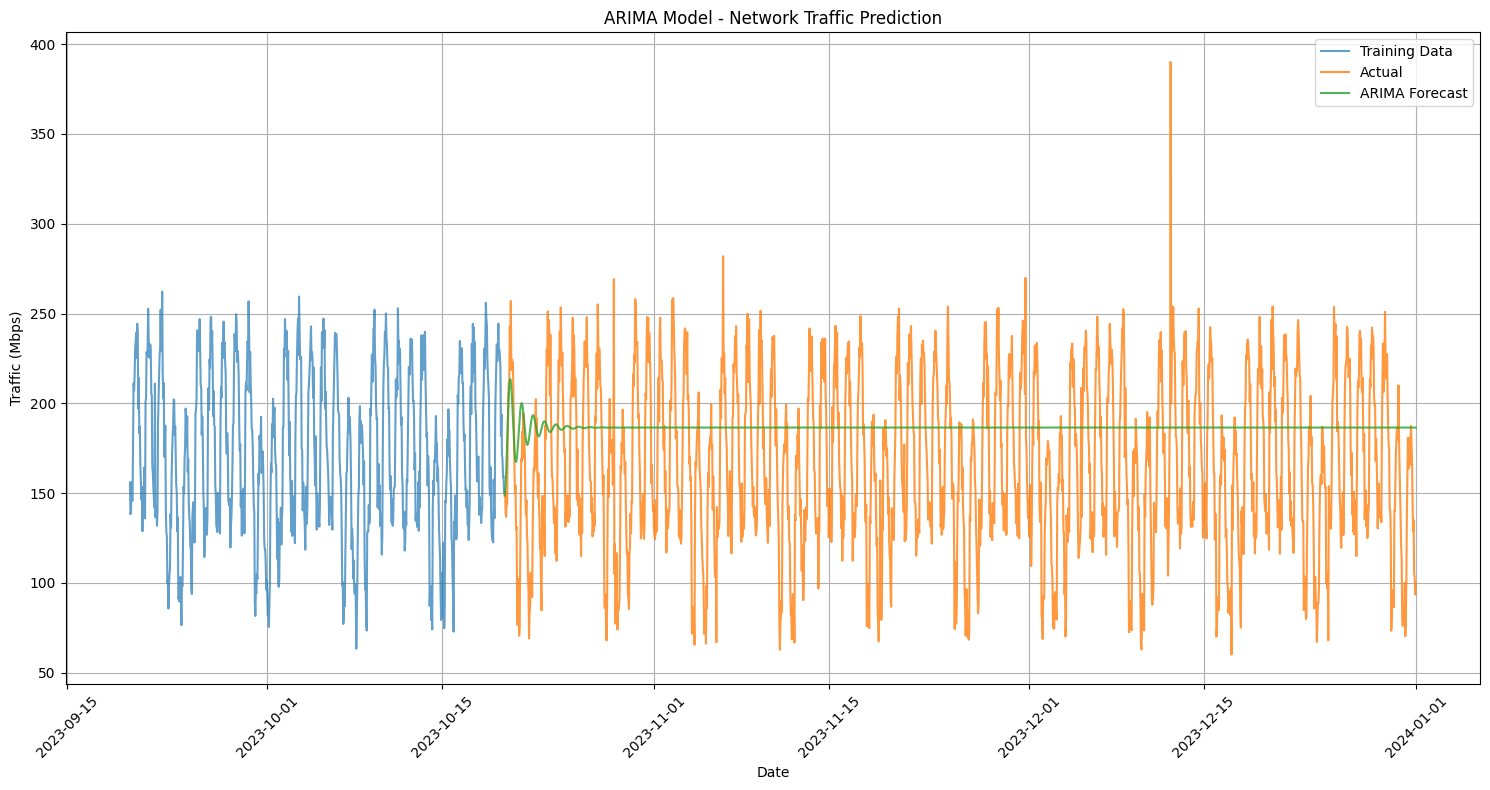

In [13]:
def build_arima_model(train_data, test_data):
    """Build and evaluate ARIMA model"""
    print("\n" + "="*50)
    print("ARIMA MODEL")
    print("="*50)
    # For simplicity, we'll use ARIMA(2,1,2) - students can experiment
    # with parameter selection
    print("\nBuilding ARIMA(2,1,2) model...")
    # Fit ARIMA model
    model = ARIMA(train_data['traffic_mbps'], order=(2,1,2))
    fitted_model = model.fit()
    print("\nARIMA Model Summary:")
    print(fitted_model.summary())
    # Make predictions
    print("\nMaking predictions on test set...")
    forecast = fitted_model.forecast(steps=len(test_data))
    # Calculate metrics
    mse = mean_squared_error(test_data['traffic_mbps'], forecast)
    mae = mean_absolute_error(test_data['traffic_mbps'], forecast)
    rmse = np.sqrt(mse)
    print(f"\nARIMA Model Performance:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    # Visualization
    plt.figure(figsize=(15, 8))
    # Plot last 30 days of training data and all test data
    plot_start = max(0, len(train_data) - 30*24)
    plt.plot(train_data.index[plot_start:],
             train_data['traffic_mbps'].iloc[plot_start:],
             label='Training Data', alpha=0.7)
    plt.plot(test_data.index, test_data['traffic_mbps'],
             label='Actual', alpha=0.8)
    plt.plot(test_data.index, forecast, label='ARIMA Forecast',
             alpha=0.8)
    plt.title('ARIMA Model - Network Traffic Prediction')
    plt.xlabel('Date')
    plt.ylabel('Traffic (Mbps)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    return fitted_model, forecast, {'MSE': mse, 'MAE': mae, 'RMSE': rmse}
arima_model, arima_forecast, arima_metrics = (
    build_arima_model(train_data, test_data)
)

====================================
=================================
PART 5: MODEL 2 - LINEAR REGRESSION WITH
ENGINEERED FEATURES
====================================
=================================


LINEAR REGRESSION MODEL WITH FEATURE ENGINEERING
Training samples after removing NaN: 6840
Test samples after removing NaN: 1584
Number of features: 16

Training Linear Regression model...

Linear Regression Model Performance:
Training MSE: 0.00
Test MSE: 0.00
Test MAE: 0.00
Test RMSE: 0.00
Test R²: 1.0000

Top 10 Most Important Features:
            feature    importance
13             ma_3  1.381545e+02
8             lag_2  4.803551e+01
7             lag_1  4.802127e+01
1          hour_cos  1.234568e-13
5   day_of_year_cos  1.101775e-13
6             trend  6.342669e-14
3       weekday_cos  5.483055e-14
14            ma_24  4.866073e-14
12          lag_168  4.812817e-14
2       weekday_sin  4.264703e-14


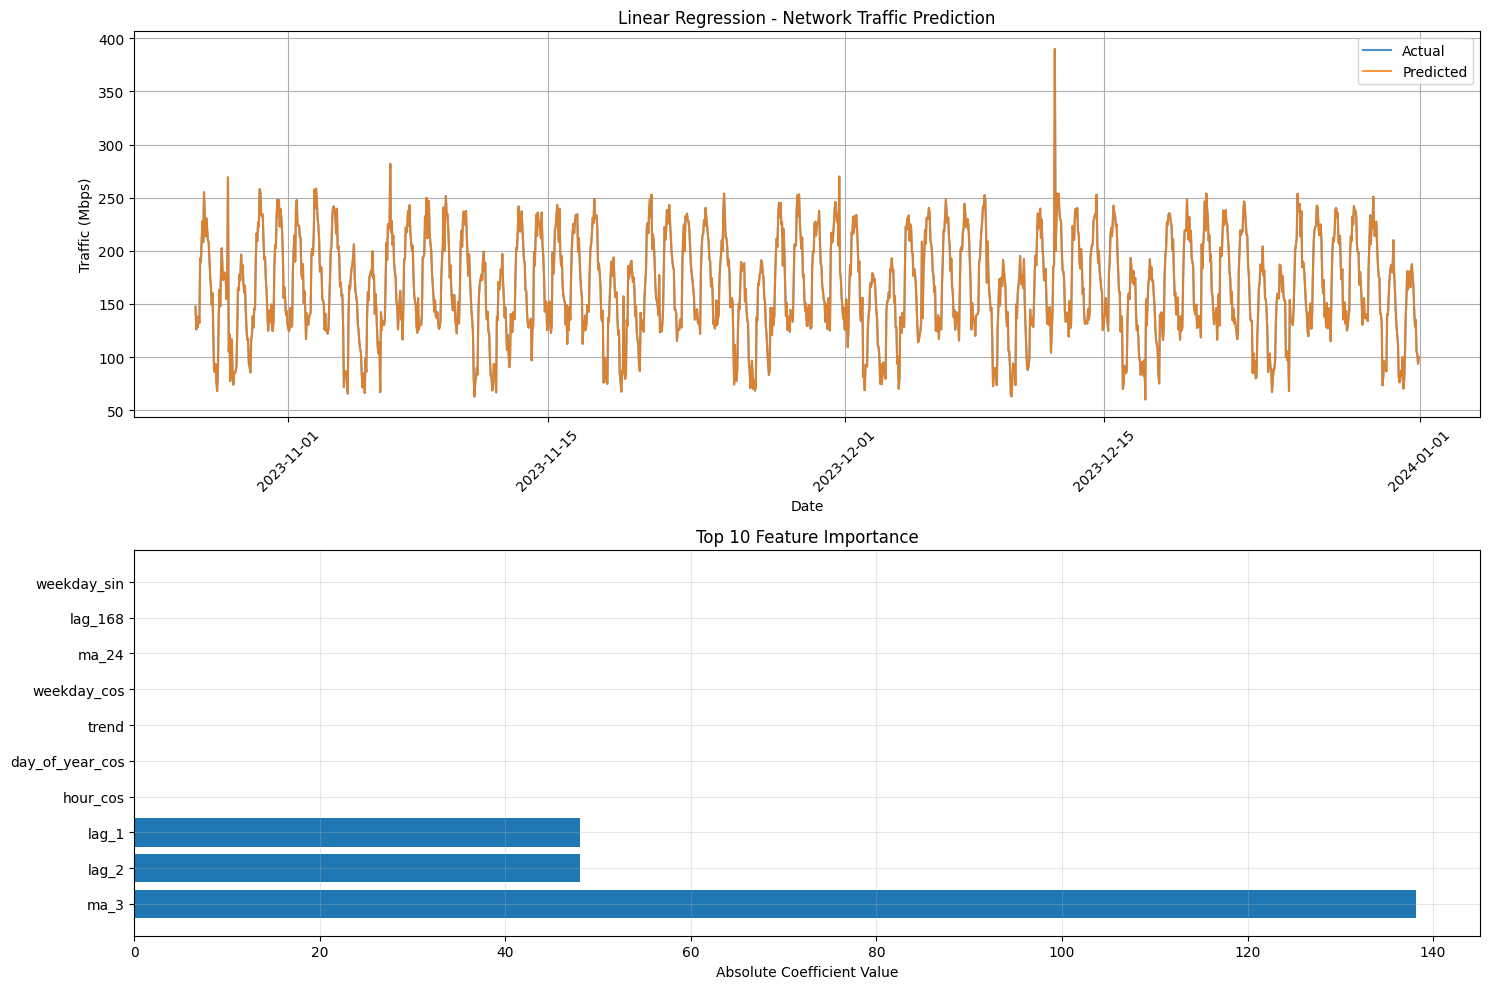

In [15]:
def build_linear_regression_model(train_data, test_data):
    """Build linear regression model with time-based features"""
    print("\n" + "="*50)
    print("LINEAR REGRESSION MODEL WITH FEATURE ENGINEERING")
    print("="*50)

    def create_features(data):
        """Create time-based features for regression"""
        features_df = data.copy()
        # Time-based features
        features_df['hour_sin'] = np.sin(2 * np.pi * features_df['hour'] / 24)
        features_df['hour_cos'] = np.cos(2 * np.pi * features_df['hour'] / 24)
        features_df['weekday_sin'] = np.sin(2 * np.pi * features_df['weekday'] / 7)
        features_df['weekday_cos'] = np.cos(2 * np.pi * features_df['weekday'] / 7)
        features_df['day_of_year_sin'] = np.sin(2 * np.pi * features_df['day_of_year'] / 365)
        features_df['day_of_year_cos'] = np.cos(2 * np.pi * features_df['day_of_year'] / 365)

        # Lagged features (using previous hours as predictors)
        for lag in [1, 2, 3, 24, 48, 168]: # 1h, 2h, 3h, 1day, 2days, 1week
            features_df[f'lag_{lag}'] = features_df['traffic_mbps'].shift(lag)

        # Moving averages
        features_df['ma_3'] = features_df['traffic_mbps'].rolling(window=3).mean()
        features_df['ma_24'] = features_df['traffic_mbps'].rolling(window=24).mean()
        features_df['ma_168'] = features_df['traffic_mbps'].rolling(window=168).mean()

        # Trend feature (time since start)
        features_df['trend'] = range(len(features_df))
        return features_df

    # Create features for both train and test sets
    train_features = create_features(train_data)
    test_features = create_features(test_data)

    # Define feature columns (excluding target and non-predictive columns)
    feature_cols = (['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos',
                     'day_of_year_sin', 'day_of_year_cos', 'trend'] +
                    [f'lag_{lag}' for lag in [1, 2, 3, 24, 48, 168]] +
                    ['ma_3', 'ma_24', 'ma_168'])

    # Remove rows with NaN values (due to lagged features)
    max_lag = max([1, 2, 3, 24, 48, 168])
    train_clean = train_features.iloc[max_lag:].copy()
    test_clean = test_features.dropna().copy()

    # Prepare training data
    X_train = train_clean[feature_cols]
    y_train = train_clean['traffic_mbps']

    # Prepare test data
    X_test = test_clean[feature_cols]
    y_test = test_clean['traffic_mbps']

    print(f"Training samples after removing NaN: {len(X_train)}")
    print(f"Test samples after removing NaN: {len(X_test)}")
    print(f"Number of features: {len(feature_cols)}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train linear regression model
    print("\nTraining Linear Regression model...")
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred_train = lr_model.predict(X_train_scaled)
    y_pred_test = lr_model.predict(X_test_scaled)

    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_pred_test)

    print(f"\nLinear Regression Model Performance:")
    print(f"Training MSE: {train_mse:.2f}")
    print(f"Test MSE: {test_mse:.2f}")
    print(f"Test MAE: {test_mae:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Test R²: {test_r2:.4f}")

    # Feature importance (absolute coefficients)
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': np.abs(lr_model.coef_)
    }).sort_values('importance', ascending=False)
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

    # Visualization
    plt.figure(figsize=(15, 10))
    # Subplot 1: Actual vs Predicted
    plt.subplot(2, 1, 1)
    plt.plot(test_clean.index, y_test, label='Actual', alpha=0.8)
    plt.plot(test_clean.index, y_pred_test, label='Predicted', alpha=0.8)
    plt.title('Linear Regression - Network Traffic Prediction')
    plt.xlabel('Date')
    plt.ylabel('Traffic (Mbps)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

    # Subplot 2: Feature Importance
    plt.subplot(2, 1, 2)
    top_features = feature_importance.head(10)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Absolute Coefficient Value')
    plt.title('Top 10 Feature Importance')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return lr_model, scaler, y_pred_test, test_clean.index, {
        'MSE': test_mse, 'MAE': test_mae, 'RMSE': test_rmse, 'R2': test_r2
    }
lr_model, scaler, lr_predictions, lr_test_index, lr_metrics = (
    build_linear_regression_model(train_data, test_data)
)
